# EXPERIMENTO 1 - DETENCION PICOS MOM


Exploramos la carpeta audio y vemos las 7 palabras que contiene la carpeta:

In [4]:
import numpy as np                 # Numpy: módulo fundamental de python para poder operar
import matplotlib.pyplot as plt    # Para poder pintar gráficas
%matplotlib inline
import os

fpaths = []       # fpaths:  'audio/apple/apple07.wav'  array path de carpeta 'audio'
labels = []       # labels: array palabras repetidas (7 veces apple, 7 veces kiwi.. etc)
spoken = []       # spoken: array palabras (no repetidas)
for f in os.listdir("audio"):  # os.listdir: nos permite buscar en una ruta determinada
                               #   (nosotros buscamos f que seria las palabras habladas)
    if f not in ".DS_Store":
        for w in os.listdir("audio/" + f):
            fpaths.append("audio/" + f + '/' + w)
            labels.append(f)
            if f not in spoken:
                spoken.append(f)
                
print('Words spoken:', spoken)

('Words spoken:', ['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach'])



#### Tenemos un total de 7 palabras diferentes: 'apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach (lo podemos ver en el array de la variable 'spoken'.

#### Cada palabra se pronunció 15 veces diferentes (lo podemos ver en la variable labels).

#### Esto nos proporciona un total de 105 archivos ( 7 palabras x 15 veces cada palabra = 105 archivos).

A continuación, los archivos se extraerán en una sola matriz de datos y se creará un vector de etiqueta con la etiqueta correcta para cada archivo de datos.

In [5]:
from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000)) # np.zeros: devuelve una nueva matriz rellena con ceros de una longitud len(fpaths)

maxsize = -1
for n,file in enumerate(fpaths):    # Con enumerate vamos a enumerar la cantidad de path que hay fpaths 
                                    # (conseguimos asi los 105 archivos)
        
    _, d = wavfile.read(file)       # Devuelve la frecuencia de muestreo y los datos de un archivo WAV
    
    data[n, :d.shape[0]] = d        # .shape nos proporciona las dimensiones de una matriz 
                                    # _ : es la frecuencia de muestreo : print(_) = 8000
                                    # d : son los datos de cada audio
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
        
data = data[:, :maxsize]
#print(maxsize)

#Each sample file is one row in data, and has one entry in labels
# Cada archivo es una fila en datos y tiene una entrada de etiquetas
print('Number of files total:', data.shape[0])

all_labels = np.zeros(data.shape[0])     #Conseguimos una matriz de 105 elementos rellenados con 0

print 'Matriz all_labels comienzo: ', all_labels

for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n   


print 'Labels and label indices', all_labels


('Number of files total:', 105)
Matriz all_labels comienzo:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Labels and label indices [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]



 #### En este momento, ya hemos convertido nuestros datos en una matriz de entrada etiquetada. A continuación, pasamos a extraer características de estos datos que aún no hemos procesado. Comenzamos con: LA DETENCIÓN DE PICOS 

- La detención de picos la haremos a través de la FFT. 

- En el artículo crea su propia implementación para la FFT pero también podemos utilizar la función del diagrama de matplotlib, como vemos a continuación:


 La idea es bastante simple: la FFT se aplica sobre los fragmentos de los datos de entrada, lo que da como resultado una "imagen" de FFT 2D, generalmente llamada espectrograma. Establecer el tamaño de FFT nos permite controlar la cantidad de resolución de frecuencia disponible, mientras que la superposición de estas ventanas nos permite controlar la resolución de tiempo al coste de aumentar el tamaño de los datos. Por lo que tendremos 3 cuadros FFT que se han extraído de la muestra de entrada X. Para nuestra extracción de características, a continuación, encontraremos picos en cada fila de STFT_X.

(216, 32)
(216, 32)


<Figure size 432x288 with 0 Axes>

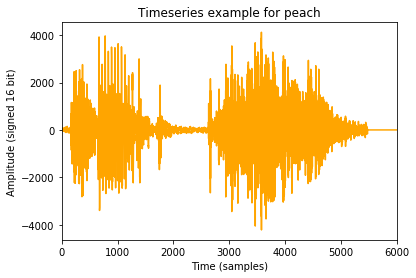

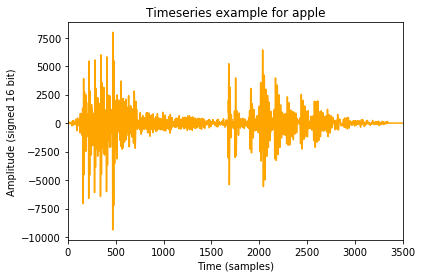

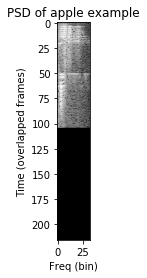

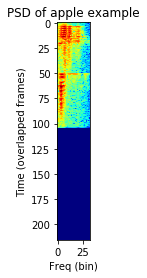

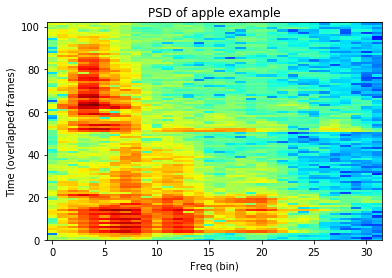

<Figure size 432x288 with 0 Axes>

In [6]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):    # Para encontrar picos en la frecuencia, se utiliza 
                                            # la Transformada de Fourier de tiempo corto (STFT).
                                            #tamaño de la ventana fftsize = 64
                                            #superposición overlap = 0.5
        
    hop = int(fftsize * (1 - overlap_pct))      # hop es el salto 
    w = scipy.hanning(fftsize + 1)[:-1]         # ventana hanning
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]
    

#####################

#   Dibujamos las señales en el tiempo

#####################


import matplotlib.pyplot as plt
plt.plot(data[95, :], color='orange')
plt.title('Timeseries example for %s'%labels[98])
plt.xlim(0, 6000)  # xlim(left,righ) -> establece los limites 
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()


import matplotlib.pyplot as plt
plt.plot(data[10, :], color='orange')
plt.title('Timeseries example for %s'%labels[10])
plt.xlim(0, 3500)    # xlim(left,righ) -> establece los limites 
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()


#####################

#   Dibujamos los espectro s

#####################


# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[10, :])) + 1)
print(log_freq.shape)

plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
#plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[10])
plt.figure()



# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[10, :])) + 1)
print(log_freq.shape)

plt.imshow(log_freq, cmap=plt.cm.jet, interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
#plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[10])
plt.figure()


plt.imshow(log_freq, cmap=plt.cm.jet, interpolation=None, aspect='auto')
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(0, 102)
# plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[10])
plt.figure()




#### A continuación vamos a buscar los picos de la FFT. 

- Se implementa un algoritmo para esto, consiste en una ventana movil que va "barriendo" la FFT.
- Hacemos una ventana de tamaño 9 (por ejemplo) la dividimos en 3 partes/secciones (izquierda, centro y derecha) y vamos buscando el punto máximo 
- Aplique alguna función (media, mediana, máxima, mínima, etc.) sobre cada sección de la ventana. Si el valor máximo de la función sobre la sección central es mayor que el resultado para la izquierda o la derecha, continúe con la siguiente verificación. De lo contrario GOTO 6. Si el valor máximo para f (CCC) está en el centro de la ventana, ¡ha encontrado un pico! Marca y continúa. De lo contrario, vaya al siguiente paso. Cambiamos los datos de entrada en una muestra y repita el proceso. 
- Una vez que se hayan procesado todos los datos, debería tener algunos picos detectados. Clasifíquelos en orden descendente por amplitud, luego emita los N picos superiores. En este caso, N = 6.:

A continuación vamos a buscar los picos de la FFT.

In [7]:
from numpy.lib.stride_tricks import as_strided

# Funcion peakfind : permite estimar aproximadamente los parámetros A,u, sig que se ajustaran a 
#la descomposicion gausiana

def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size   # Tamaño de la ventana 
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)  # Cree una vista en la matriz con la forma y 
                                                      # los pasos dados.
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]


(32,)
[16003    -1    -1    -1    -1    -1]
[24 27 14  5  6  7]

[24]
[16003]


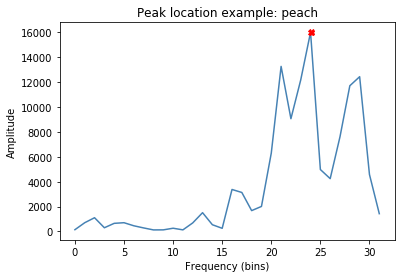

In [8]:
plot_data = np.abs(stft(data[95, :])) [10, :]     #  Funcion abs se usa para devolver el valor absoluto de un numero 
                                                #  (devolver un entero, sin comas) 
print(plot_data.shape)
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'X', color='red')    # color: darkred
plt.title('Peak location example: %s'%labels[95])
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')
print(values)
print(locs)
print
print(fp)
print fv

[ 1.04620863e+04  9.68992384e+03  4.14521982e+03 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
[ 4 12 20 14  5  6]

[ 4 12 20]
[10462.08627625  9689.92384244  4145.2198188 ]


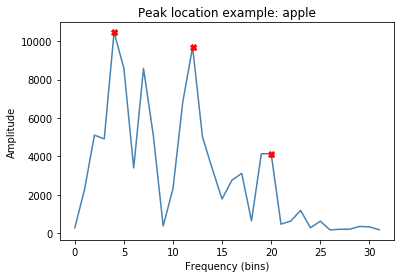

In [9]:
plot_data = np.abs(stft(data[10, :]))[20, :]    

values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'X', color='red')   
plt.title('Peak location example: %s'%labels[10])
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')
print(values)
print(locs)
print
print fp
print fv

#### El detector de picos hace un trabajo aceptable en la detección de picos, aunque de ninguna manera es perfecto. Uno de los factores limitantes aquí es la longitud de la FFT: este detector de picos actualmente está buscando más de 9 fragmentos de muestra, ¡lo cual es muy grande cuando el tamaño de la FFT es de solo 64 contenedores! Una vez más, esto tendrá un impacto negativo en el rendimiento. Podríamos establecer el tamaño de FFT más grande, pero al probar este algoritmo, los tamaños de FFT más largos parecían empeorar, incluso con una mayor superposición para mantener la misma resolución de tiempo. En última instancia, aquí es donde entran en juego características más avanzadas.


Extrapolamos la detención de picos para toda nuestra matriz de datos:

In [10]:
import time
from datetime import datetime

all_obs = []

start = time.strftime("%H:%M:%S")

for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
  
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
       
    if i % 10 == 0:
        print("Processed obs %s" % i)
        print obs
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

finish = time.strftime("%H:%M:%S")


format = '%H:%M:%S'
print (start)
print(finish)
time = datetime.strptime(finish, format) - datetime.strptime(start, format)
print time



Processed obs 0
[[ 9.  4.  6. ... 27. 27. 27.]
 [17. 24. 12. ... 26. 26. 26.]
 [23. 14. 21. ...  5.  5.  5.]
 [27.  5. 27. ...  6.  6.  6.]
 [14.  6. 14. ...  7.  7.  7.]
 [ 5.  7.  5. ...  8.  8.  8.]]
Processed obs 10
[[ 6.  6.  6. ... 27. 27. 27.]
 [19. 20. 20. ... 26. 26. 26.]
 [27. 27. 27. ...  5.  5.  5.]
 [14. 14. 14. ...  6.  6.  6.]
 [ 5.  5.  5. ...  7.  7.  7.]
 [ 7.  7.  7. ...  8.  8.  8.]]
Processed obs 20
[[ 6.  7. 14. ... 27. 27. 27.]
 [25. 18. 27. ... 26. 26. 26.]
 [19. 26. 26. ...  5.  5.  5.]
 [27. 27.  5. ...  6.  6.  6.]
 [14. 14.  6. ...  7.  7.  7.]
 [ 5.  5.  7. ...  8.  8.  8.]]
Processed obs 30
[[25. 24. 11. ... 27. 27. 27.]
 [27. 18. 16. ... 26. 26. 26.]
 [14. 12. 22. ...  5.  5.  5.]
 [ 5. 27. 27. ...  6.  6.  6.]
 [ 6. 14. 14. ...  7.  7.  7.]
 [ 7.  5.  5. ...  8.  8.  8.]]
Processed obs 40
[[14. 14. 10. ... 27. 27. 27.]
 [27. 19. 25. ... 26. 26. 26.]
 [26. 27. 27. ...  5.  5.  5.]
 [ 5.  5. 14. ...  6.  6.  6.]
 [ 6.  6.  5. ...  7.  7.  7.]
 [ 7.  7.  6.

Ejemplo Algoritmo MODELOS OCULTOS DE MARKOV (HMMs)

In [11]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
('M1:', 221.38828575112734)
('M2:', 165.27280230776483)
Prediction for test set 1
('Model', 1)
()
Likelihoods for test set 2
('M1:', 33.19459421485196)
('M2:', 59.15274753052989)
Prediction for test set 2
('Model', 2)


A continuación, dividimos la matriz en test y training (como la base de datos es pequeña, utilizamos StratifiedShuffleSplit para no malgastar) 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss.split(all_obs, all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)

print('Size of testing matrix:', X_test.shape)

('Size of training matrix:', (52, 6, 216))
('Size of testing matrix:', (53, 6, 216))


Para predecir las palabras, entrenamos varias veces el modelo. Y mostramos cuenta es la probabilidad de acierto en nuestro modelo: 

In [15]:
ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)

print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 81.13 percent


#### Por último, finalizamos nuestro estudio visualizando la matriz de confusión.

La matriz de confusión nos facilitará ver si el sistema está confundiendo dos clases:

Text(0.5,0,'Predicted label')

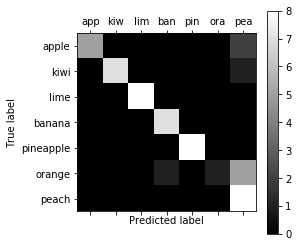

In [26]:


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:3] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
#plt.title('Confusion matrix, single speaker')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')


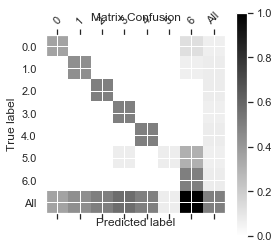

In [213]:
import pandas as pd
  # Matriz de confusion normalizada 

df_confusion = pd.crosstab(y_test, predicted_labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

    
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_conf_norm, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_conf_norm, cmap=cmap) # imshow
    
    plt.title('Matrix Confusion')
    plt.colorbar()
    tick_marks = np.arange(len(df_conf_norm.columns))
    plt.xticks(tick_marks, df_conf_norm.columns, rotation=45)
    plt.yticks(tick_marks, df_conf_norm.index)
    #plt.tight_layout()
    plt.ylabel(df_conf_norm.index.name)
    plt.xlabel(df_conf_norm.columns.name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plot_confusion_matrix(df_conf_norm)



In [214]:
from pandas_ml import ConfusionMatrix
y_actu = y_test
y_pred = predicted_labels
cm = ConfusionMatrix(y_actu, y_pred)
cm.print_stats()

Confusion Matrix:

Predicted  0  1  2  3  4  5   6  __all__
Actual                                  
0          5  0  0  0  0  0   2        7
1          0  7  0  0  0  0   1        8
2          0  0  8  0  0  0   0        8
3          0  0  0  7  0  0   0        7
4          0  0  0  0  8  0   0        8
5          0  0  0  1  0  1   5        7
6          0  0  0  0  0  0   8        8
__all__    5  7  8  8  8  1  16       53


Overall Statistics:

Accuracy: 0.8301886792452831
95% CI: (0.7019783318945976, 0.9192911235331771)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.4764402793768287e-15
Kappa: 0.8011671529804085
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1         2  \
Population                                    53         53        53   
P: Condition positive                          7          8         8   
N: Condition negative                         46         45        45   
Test outcome positive           

-------------------------------------
## FORMA POCO INTUITIVA - NO TENER EN CUENTA ESTA MATRIZ
-------------------------------------


#### Normalmente la matriz de confusión es con números. 
#### Probamos con "matshow" : 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 8]]


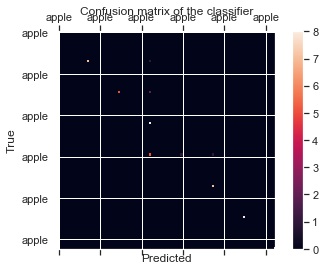

In [215]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, predicted_labels, all_labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

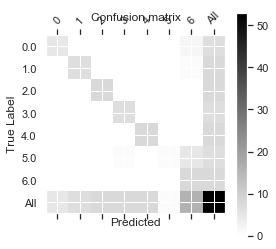

In [216]:
from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_matrix(y_test, predicted_labels)
df_confusion = pd.crosstab(y_test, predicted_labels)
df_confusion = pd.crosstab(y_test, predicted_labels, rownames=['True Label'], colnames=['Predicted'], margins=True)


import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    

plot_confusion_matrix(df_confusion)

# Representacion de Matriz de confusion para el modelo

- Tasa de clasificacion/prediccion:
Accuracy = (TP + TN) / (TP + TN + FP + FN)= 0.81

- Recall : nos da una idea de cuándo es realmente sí, con qué frecuencia predice sí.
Recuperación = TP / (TP + FN) = 

- Precision : nos dice cuándo predice sí, con qué frecuencia es correcta.
Precisión = TP / (TP + FP) = 100 / (100 + 10) = 0.81




In [217]:
# Python script for confusion matrix creation. 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
actual = y_test 
predicted = predicted_labels
results = confusion_matrix(actual, predicted) 
print 'Confusion Matrix :'
print(results) 
print 'Accuracy Score :',accuracy_score(actual, predicted)*100 
print 'Report : '
print classification_report(actual, predicted, target_names= spoken) 



Confusion Matrix :
[[5 0 0 0 0 0 2]
 [0 7 0 0 0 0 1]
 [0 0 8 0 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 0 8 0 0]
 [0 0 0 1 0 1 5]
 [0 0 0 0 0 0 8]]
Accuracy Score : 83.01886792452831
Report : 
              precision    recall  f1-score   support

       apple       1.00      0.71      0.83         7
        kiwi       1.00      0.88      0.93         8
        lime       1.00      1.00      1.00         8
      banana       0.88      1.00      0.93         7
   pineapple       1.00      1.00      1.00         8
      orange       1.00      0.14      0.25         7
       peach       0.50      1.00      0.67         8

   micro avg       0.83      0.83      0.83        53
   macro avg       0.91      0.82      0.80        53
weighted avg       0.91      0.83      0.81        53



- Micro avg: promedio de la media no ponderada por etiqueta
- Macro avg: el promedio ponderado (promedio de la media ponderada por soporte por etiqueta) 
- weighted avg: el promedio de la muestra (solo para la clasificación de múltiples etiquetas)


### CONCLUSIONES: 

* Mayor precisión, Menor Recall: los ejemplos que predecimos cómo positivos son realmente positivos. Ejemplo:   ORANGE (cuando la reconoce, la reconoce bien,la acierta).

* Menor precisión, Mayor Recall: la mayoría de los ejemplos positivos se reconocen correctamente pero hay muchos falsos positivos. Ejemplo:  PEACH (muchos falsos positvios, cuando la etiqueta como PEACH muchas veces no es correcto).

* Palabras problemáticas: banana,  pineaple, orange, peach. 

* Palabras 100% RECONOCIDAS: apple, lime.

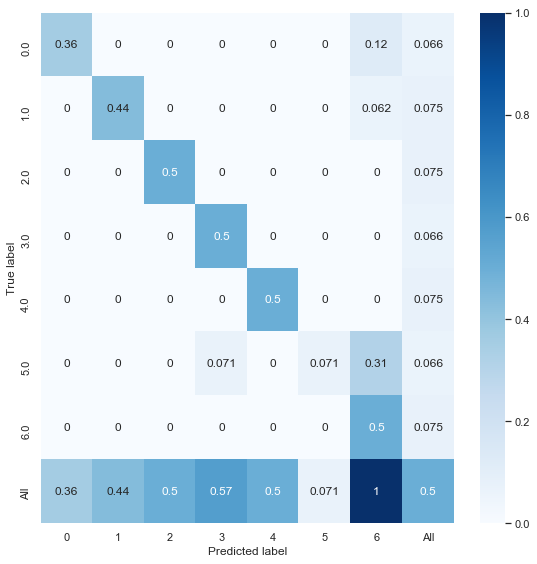

In [218]:
import pandas as pd
classes=[0,1,2,3,4,5,6]
classes_test = ['apple', 'kiwi', 'lime','banana', 'pineapple', 'orange', 'peach']


df_confusion = pd.crosstab(y_test, predicted_labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)


import seaborn as sns; 
sns.set()


figure = plt.figure(figsize=(8, 8))
sns.heatmap(df_conf_norm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()